In [2]:
import numpy as np
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import time


In [3]:
class Layer:
    """
    The base layer class for all layers

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the layer class

        Parameters:
            name: The name of the layer
        """

        self.name = name
        self.input_shape = None
        self.output_shape = None

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            x: The input to the layer

        Returns:
            The output of the layer
        """

        raise NotImplementedError

    def backward(self, output_grad, learning_rate):
        # we can use an optimizer instead of learning rate
        """
        The backward pass of the layer

        Parameters:
            grad: The gradient of the loss w.r.t. the output of the layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        raise NotImplementedError

In [60]:
def xavier_initialization(m, n):
    """
    Xavier initialization for the weights of a layer

    Parameters:
        m: The number of rows in the weight matrix
        n: The number of columns in the weight matrix

    Returns:
        The initialized weights
    """

    random.seed(82)
    
    std_dev = np.sqrt(2.0 / (m + n))
    return np.random.normal(0, std_dev, size=(m, n))

In [65]:
class DenseLayer(Layer):
    """
    The dense layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
        weights: The weights of the layer
        bias: The bias of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, input_shape, output_shape):
        """
        The constructor for the dense layer class

        Parameters:
            name: The name of the layer
            input_shape: The shape of the input to the layer
            output_shape: The shape of the output of the layer
        """

        super().__init__(name)
        self.input_shape = input_shape
        self.output_shape = output_shape
     

        # Xavier initialization
        
        self.weights = xavier_initialization(self.output_shape, self.input_shape)
        
        self.bias = np.zeros((self.output_shape, 1))

        # print ("in Xaviar init: ")
        # print ("weights: \n", self.weights)
        # print ("bias: \n", self.bias)

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        self.input = input

        # print ("input shape: ", self.input.shape)
        # print ("weights shape: ", self.weights.shape)
        # print ("bias shape: ", self.bias.shape)

        return np.dot(self.weights, self.input) + self.bias
    

    def backward(self, output_grad, learning_rate):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
     
        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """
        # output_grad: dL/dy (L: loss, y: output of the layer)
        # output_grad: The gradient of the loss w.r.t. the output of the layer

        weights_grad = np.dot(output_grad, self.input.T)
        # dL/dB = dL/dy * dy/dB = dL/dy * 1
        bias_grad = output_grad

        # input_grad: dL/dx
        input_grad = np.dot(self.weights.T, output_grad)

    
        self.weights -= learning_rate * weights_grad
        self.bias -= learning_rate * bias_grad

        return input_grad

In [6]:
class ActivationLayer(Layer):
    """
    The activation layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, activation_func, activation_func_prime):
        """
        The constructor for the activation layer class

        Parameters:
            name: The name of the layer
            activation_func: The activation function of the layer
            activation_func_prime: The derivative of the activation function of the layer
        """

        super().__init__(name)

    
        self.activation_func = activation_func
        self.activation_func_prime = activation_func_prime

        

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        self.input = input

        return self.activation_func(input)

    def backward(self, output_grad, learning_rate):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
            learning_rate: dummy for activation layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        return np.multiply(output_grad, self.activation_func_prime(self.input))
    

In [7]:
class SoftmaxLayer(Layer):
    """
    The softmax layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the softmax layer class

        Parameters:
            name: The name of the layer
        """

        super().__init__(name)

    def forward(self, input):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        z = input - max(input)
        numerator = np.exp(z)
        denominator = np.sum(numerator)
        self.output =  numerator / denominator
        return self.output


    def backward(self, output_grad, learning_rate):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
            learning_rate: dummy for softmax layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        n = np.size(self.output)
        
        tmp = np.tile(self.output, n)
        # tile: construct an array by repeating A the number of times given by reps
        

        return np.dot(tmp * (np.identity(n) - np.transpose(tmp)), output_grad)
        # * is element-wise multiplication, not matrix multiplication




In [45]:
class DropoutLayer(Layer):
    """
    The dropout layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
        dropout_rate: The dropout rate of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name, dropout_rate):
        """
        The constructor for the dropout layer class

        Parameters:
            name: The name of the layer
            dropout_rate: The dropout rate of the layer
        """

        super().__init__(name)
        self.dropout_rate = dropout_rate
        self.dropout_mask = None
  

    def forward(self, input, training = True):
        """
        The forward pass of the layer

        Parameters:
            input: The input to the layer

        Returns:
            The output of the layer
        """

        if not training:
            return input

        self.input = input

        np.random.seed(82)
        D1 = np.random.rand(*input.shape) < (1 - self.dropout_rate)
        # D1 is a binary mask
        # print ("D1: \n", D1)

        self.dropout_mask = D1 / (1 - self.dropout_rate)

        # print ("dropout mask: \n", self.dropout_mask)

        return np.multiply(input, self.dropout_mask) / (1 - self.dropout_rate)
        # h/(1-p)

    def backward(self, output_grad, learning_rate):
        """
        The backward pass of the layer

        Parameters:
            output_grad: The gradient of the loss w.r.t. the output of the layer
            learning_rate: dummy for dropout layer

        Returns:
            The gradient of the loss w.r.t. the input of the layer
        """

        return np.multiply(output_grad, self.dropout_mask) / (1 - self.dropout_rate)

In [9]:
class ReLUActivationLayer(ActivationLayer):
    """
    The ReLU activation layer class

    Attributes:
        name: The name of the layer
        input_shape: The shape of the input to the layer
        output_shape: The shape of the output of the layer
    
    Methods:
        forward: The forward pass of the layer
        backward: The backward pass of the layer
    """

    def __init__(self, name):
        """
        The constructor for the ReLU activation layer class

        Parameters:
            name: The name of the layer
        """

        super().__init__(name, lambda x: np.maximum(x, 0), lambda x: np.where(x > 0, 1, 0))



Cross Entropy loss

In [10]:
def cross_entropy_loss(y, y_pred):
    """
    The cross entropy loss function

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The loss
    """


    epsilon = 1e-15  # small value to avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    # limits the values in the y_pred array to be within the range 
    # [epsilon, 1 - epsilon]. This ensures that the predicted probabilities are not exactly zero or one
    
    # print ("in cross entropy loss")
    # print ("y size: ", y.size)
    # print ("y_pred: ", y_pred)

    return -np.sum(np.multiply(y, np.log(y_pred))) / y.size



def cross_entropy_loss_prime(y, y_pred):
    """
    The derivative of the cross entropy loss function with respect to the y_pred

    Parameters:
        y: The ground truth
        y_pred: The predictions

    Returns:
        The derivative of the loss w.r.t. the predictions
    """


    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # print ("in cross entropy loss prime")
    # print ("y size: ", y.size)
    # print ("y_pred: ", y_pred)
    
    return -np.divide(y, y_pred) / y.size

Optimizer

In [12]:
class AdamOptimizer:
    def __init__(self, learning_rate=5e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None  # First moment estimate
        self.v = None  # Second moment estimate
        self.t = 0  # Time step

    def update(self, gradients):
        if self.m is None:
            self.m = np.zeros_like(gradients)
            self.v = np.zeros_like(gradients)

        self.t += 1

        # Update biased first moment estimate
        self.m = self.beta1 * self.m + (1 - self.beta1) * gradients

        # Update biased second moment estimate
        self.v = self.beta2 * self.v + (1 - self.beta2) * (gradients ** 2)

        # Correct the bias in the moment estimates
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        # Update the parameters
        update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
        
        return update

Moodle instructed dataset loading

In [38]:
import torchvision.datasets as ds
from torchvision import transforms


train_validation_dataset = ds.EMNIST(root='./data', split='letters',
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)


independent_test_dataset = ds.EMNIST(root='./data', split='letters',
                             train=False,
                             transform=transforms.ToTensor())



In [34]:
train_validation_dataset

Dataset EMNIST
    Number of datapoints: 124800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [15]:
independent_test_dataset

Dataset EMNIST
    Number of datapoints: 20800
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [39]:
# Split the train-validation dataset as 85%-15% to form your train set and validation set using sklearn.model_selection.train_test_split

from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_validation_dataset, test_size=0.15, random_state=82)


Visualization

In [17]:
def show_images(dataset, num_images=10):
    """
    Show the first num_images images of the dataset

    Parameters:
        dataset: The dataset to show the images from
        num_images: The number of images to show
    """

    # Create a figure to display the images
    fig = plt.figure()

    # Loop over the first num_images images in the dataset
    for i in range(num_images):
        # Get the image and its label
        image, label = dataset[i]

        # The image needs to be transposed to be displayed correctly
        image = image.transpose(0,2).transpose(0,1)

        # Display the image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')

    # Display the figure
    plt.show()

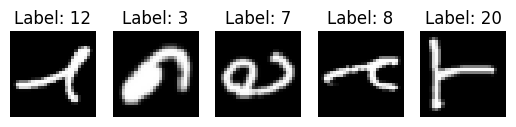

In [18]:
show_images(train_dataset)

Preprocessing

In [40]:
def preprocess_data(x, y):

    # normalize x
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x.reshape(x.shape[0], 28 * 28))
    x = x.reshape(x.shape[0], 28 * 28, 1)

    # convert class labels to one-hot encoded, should have shape (?, 26, 1)
    # 26 classes: 26 letters, for example, C is 3rd letter, then C is represented as [0, 0, 0, 1, 0, ...]
    # one hot encoding
    y = np.eye(27)[y]
    # print ("y\n", y)

    print ("y shape: ", y.shape)
    
    y = y.reshape(y.shape[0], 27, 1)

    return x, y


In [41]:
X = np.array([np.array(x[0]).flatten() for x in train_dataset])
Y = np.array([x[1] for x in train_dataset])

X_validation = np.array([np.array(x[0]).flatten() for x in validation_dataset])
Y_validation = np.array([x[1] for x in validation_dataset])

X_test = np.array([np.array(x[0]).flatten() for x in independent_test_dataset])
Y_test = np.array([x[1] for x in independent_test_dataset])


X, Y = preprocess_data(X, Y)
X_validation, Y_validation = preprocess_data(X_validation, Y_validation)
X_test, Y_test = preprocess_data(X_test, Y_test)

y shape:  (106080, 27)
y shape:  (18720, 27)
y shape:  (20800, 27)


Train the model

In [66]:

# XOR dataset

# X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
# # print ("X: ", X)
# Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    DenseLayer("Dense1", X.shape[1], 72),
    ReLUActivationLayer("ReLU1"),
    DropoutLayer("Dropout1", 0.3),
    DenseLayer("Dense2", 72, 27),
    SoftmaxLayer("Softmax")
]


learning_rate = 5e-3
epochs = 50

adam_optimizer = AdamOptimizer(learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8)

for epoch in range(epochs):
    loss = 0

    # use minibatch gradient descent
    batch_size = 1024
    num_batches = int(np.ceil(X.shape[0] / batch_size))
    # print ("num batches: ", num_batches)

    random.seed(82)
    # zip the data and shuffle
    zipped_data = list(zip(X, Y))

    random.shuffle(zipped_data)

    for i in tqdm(range(num_batches)):
        # print ("batch: ", i)
        
        # get the minibatch
        batching_time = time.time()
        batch = zipped_data[i * batch_size : (i + 1) * batch_size]

        # unzip the minibatch
        X_batch, Y_batch = zip(*batch)

        batching_time = time.time() - batching_time
        # print ("batching time: ", batching_time)

        loop_time = time.time()
        for x, y in zip(X_batch, Y_batch):
            output = x
            # print ("output: ", output)

            forward_time_start  = time.time()
            for layer in network:
                # print ("layer: ", layer.name)
                output = layer.forward(output)
                # print ("output: \n", output)


            forward_time = time.time() - forward_time_start

            # print("forward time: ", forward_time)

            # loss += mse_loss(y, output)
            # output_grad = mse_loss_prime(y, output)

            loss_grad_time_start = time.time()

            loss += cross_entropy_loss(y, output)
            output_grad = cross_entropy_loss_prime(y, output)


            # print ("loss: \n", loss)
            # print ("output grad: \n", output_grad)


            

            loss_grad_time = time.time() - loss_grad_time_start
            # print("loss grad time: ", loss_grad_time)


            backward_time_start = time.time()
            for layer in reversed(network):
                output_grad = layer.backward(output_grad, learning_rate)
                # print ("layer: ", layer.name)
                # print ("output grad: \n", output_grad)

                # ADAM
                # if isinstance(layer, DenseLayer):  # Check if the layer is DenseLayer
                #     # Access and update the parameters using AdamOptimizer
                #     layer.weights -= adam_optimizer.update(layer.weights_gradient)
                #     layer.biases -= adam_optimizer.update(layer.biases_gradient)

            backward_time = time.time() - backward_time_start
            # print("backward time: ", backward_time)

     
        loop_time = time.time() - loop_time
        # print ("loop time: ", loop_time)
    
    print(f'Epoch {epoch + 1}: Loss = {loss}')

        

 48%|████▊     | 50/104 [01:03<01:20,  1.50s/it]

In [57]:
def test_model(network, X_test, Y_test):

# test the model

# print ("X_test: ", X_test)
# print ("X_test shape:", X_test.shape)

# print ("Y_test: ", Y_test)
# print ("Y_test shape:", Y_test.shape)


    output_list = []
    for x in X_test:
        output = x
        for layer in network:
            # if isinstance(layer, DropoutLayer):
                # output = layer.forward(output, training=False)
                
            # else:
            output = layer.forward(output)

        output_list.append(output)

        
    # print ("output: ", output_list)

    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

    y_true = np.argmax(Y_test, axis=1)
    y_pred = np.argmax(output_list, axis=1)

    # print ("y_true: ", y_true)
    # print ("y_pred: ", y_pred)


    print ("accuracy: ", accuracy_score(y_true, y_pred))
    print ("precision: ", precision_score(y_true, y_pred, average='macro'))
    print ("recall: ", recall_score(y_true, y_pred, average='macro'))
    print ("f1 score: ", f1_score(y_true, y_pred, average='macro'))

    # print ("confusion matrix: ")
    # print (confusion_matrix(y_true, y_pred))





Training accuracy

In [59]:
test_model(network, X, Y)

accuracy:  0.7669777526395174
precision:  0.7801897216207745
recall:  0.7669105210921807
f1 score:  0.7673200592006401


Validation dataset for model selection

In [58]:
test_model(network, X_validation, Y_validation)


accuracy:  0.7411324786324787
precision:  0.7553494770742137
recall:  0.7415243521355392
f1 score:  0.7411517640602464


Independent test dataset

In [55]:
test_model(network, X_test, Y_test)


y_true:  [[ 1]
 [ 1]
 [ 1]
 ...
 [26]
 [26]
 [26]]
y_pred:  [[ 1]
 [17]
 [ 1]
 ...
 [26]
 [26]
 [26]]
accuracy:  0.7474519230769231
precision:  0.7589957384036651
recall:  0.7474519230769231
f1 score:  0.747020009026171
